In [1]:
from simulation import citygraph_dataset
# from learning import inductive_route_learning, eval_route_generator, bee_colony
from learning.bee_colony import main as main_bee  # я так обозвал
from learning.eval_route_generator import main as main_eval # я так обозвал
from omegaconf import OmegaConf, DictConfig
from simulation import drawing

from tqdm import tqdm
from pathlib import Path

In [2]:
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf
import os

cfg_dir = os.path.abspath("../TNDP_learning/cfg")

### Обучение LC

In [3]:
with initialize_config_dir(config_dir=cfg_dir, job_name="app"):
    cfg_learn = compose(config_name="ppo_20nodes_copy.yaml", # в этот файл можно положить путь к пикл файлу с графами, также можно попробовать другие параметры на обучение
                            overrides=["+run_name=train_1"]) # при желании можно накинуть ему имя 


/tmp/ipykernel_20505/3896539573.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=cfg_dir, job_name="app"):


In [4]:
cfg_learn

{'ppo': {'n_iterations': 200, 'val_period': 1, 'n_epochs': 1, 'minibatch_size': 2, 'horizon': 120, 'epsilon': 0.2, 'use_gae': True, 'gae_lambda': 0.95}, 'discount_rate': 0.95, 'diff_reward': True, 'baseline_lr': 0.0005, 'entropy_weight': 0.0, 'batch_size': 2, 'reward_scale': 1.0, 'lr': 0.0016134816080499328, 'decay': 0.0008404361781997002, 'optimizer': 'Adam', 'eval': {'n_routes': 15, 'min_route_len': 10, 'max_route_len': 25}, 'dataset': {'type': 'mumford', 'path': '/root/TNDP_learning/CEC2013Supp/Instances', 'city': 'VO'}, 'experiment': {'logdir': 'training_logs', 'anomaly': False, 'cpu': False, 'seed': 0, 'symmetric_routes': True, 'cost_function': {'type': 'mine', 'kwargs': {'mean_stop_time_s': 0, 'avg_transfer_wait_time_s': 300, 'demand_time_weight': 0.33, 'route_time_weight': 0.33, 'median_connectivity_weight': 0.33, 'constraint_violation_weight': 5.0, 'variable_weights': True, 'pp_fraction': 0.33, 'op_fraction': 0.33}}}, 'model': {'common': {'dropout': 0.0, 'nonlin_type': 'ReLU', 

: 

In [5]:
from learning import inductive_route_learning
inductive_route_learning.setup_and_train(cfg_learn) # веса для модели вернутся в папку output, там будет файл .pt / при желании можно накинуть ему имя 

  0%|          | 0/200 [00:00<?, ?it/s]

AssertionError: invalid cost was computed!

### Стартовый набор маршрутов

In [ ]:
with initialize_config_dir(config_dir=cfg_dir, version_base=None):
    
    cfg_eval = compose(
        config_name="eval_model_mumford",   # из @hydra.main
        overrides=[
            "+eval=mandl", # конфиг в котором задается кол-во маршрутов и их макс и мин длины (можно заменить на vo для теста по ваське)
            "+model.weights=../TNDP_learning/output/inductive_train_1_checkpoints/iter1.pt", # путь к весам модели
            "++eval.dataset.path=../TNDP_learning/CEC2013Supp/Instances", # путь к данным (можно заменить на ваську)
            "++eval.dataset.city=VO", # название города из датасетов, при тесте на ваське написать VO
            "++run_name=test" # имя запуска, вернет pickle файл с тензором в output_routes
        ]
    )

In [ ]:
# print(OmegaConf.to_yaml(cfg_eval)) # чисто проверка как выглядит конфиг 

In [ ]:
main_eval(cfg_eval)

  0%|          | 0/1 [00:00<?, ?it/s]2025-07-29 19:47:23.764 | WARNING  | iduedu.utils.utils:keep_largest_strongly_connected_component:27 - Graph contains 82 weakly connected components. This means the graph has disconnected groups if edge directions are ignored. Component sizes:: [1, 1, 1, 1, 1, 14, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2025-07-29 19:47:23.766 | WARNING  | iduedu.utils.utils:keep_largest_strongly_connected_component:37 - Removing 94 nodes from 81 smaller strongly connected components. These are subgraphs where nodes are internally reachable but isolated from the rest. Retaining only the largest strongly connected component (14 nodes).
2025-07-29 19:47:24.771 | WARNING  | iduedu.utils.utils:keep_largest_strongly_connected_component:27 - Graph contains 85 weakly connected components

,6.000,5.793,17.811,99.880,3.397,3.246,2.557,90.800,5021.500,0.000,0.381,109.278,0.000



/root/TNDP_learning/learning/utils.py:320: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  out_stats = (final_costs.mean(), final_costs.std(), metrics)


In [ ]:
# Загрузка объекта из файла
import pickle
with open('/root/TNDP_learning/output_routes/nn_construction_test_routes.pkl', 'rb') as f:
    data = pickle.load(f)

print(data)

[tensor([[107, 106, 100,  96,  91,  88,  87,  86],
        [ 91,  74,  73,  72,  49,  48,  47,  46],
        [ 53,  28,  29,   2,  31,  16,  17,  19],
        [ 44,  24,  25,  27,  29,   2,  31,  32],
        [ 63,   3,  36,  37,  39,  18,  19,  -1],
        [ 53,  51,  49,  68,  70,  72,  65,  -1]])]


<Axes: >

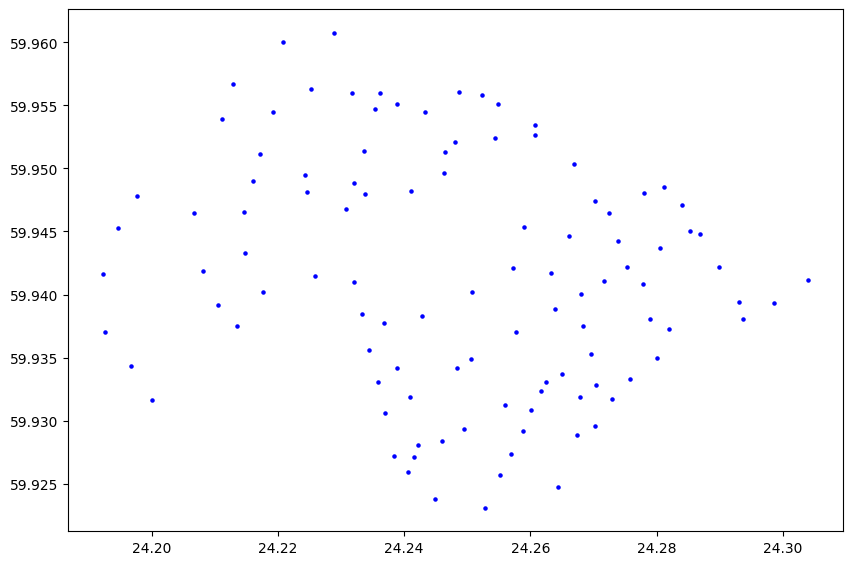

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
# 1. Загрузим координаты
coord_file = "CEC2013Supp/Instances/VOCoords.txt"

# 1. Загрузка координат
with open(coord_file, "r") as f:
    lines = f.readlines()[1:]  # Пропускаем первую строку (кол-во точек)
coords = [list(map(float, line.strip().split())) for line in lines]
df = pd.DataFrame(coords, columns=["x", "y"])

# 2. Создание GeoDataFrame в системе UTM (метры)
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["x"], df["y"]),
    crs="EPSG:32635"  # UTM зона 35N, Санкт-Петербург
)

# # 3. Преобразование в WGS84 (широта/долгота)
gdf = gdf.to_crs("EPSG:4326")
gdf['id'] = gdf.index

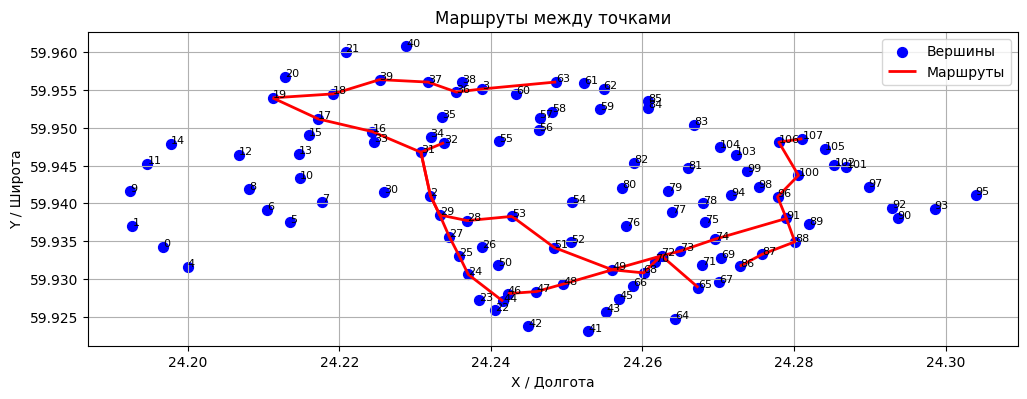

In [ ]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Ваш тензор (маршруты)
routes = [
    [107, 106, 100, 96, 91, 88, 87, 86],
    [91, 74, 73, 72, 49, 48, 47, 46],
    [53, 28, 29, 2, 31, 16, 17, 19],
    [44, 24, 25, 27, 29, 2, 31, 32],
    [63, 3, 36, 37, 39, 18, 19, -1],
    [53, 51, 49, 68, 70, 72, 65, -1]
]

# Создаем направленный граф
G = nx.DiGraph()

# Добавляем вершины с координатами
for idx, row in gdf.iterrows():
    G.add_node(row['id'], pos=(row['geometry'].x, row['geometry'].y))

# Добавляем ребра на основе маршрутов из тензора
for route in routes:
    for i in range(len(route) - 1):
        if route[i] != -1 and route[i + 1] != -1:
            G.add_edge(route[i], route[i + 1])

# Создаем GeoDataFrame для ребер (маршрутов)
edges_gdf = []
for route in routes:
    route_coords = []
    for node_id in route:
        if node_id != -1:
            point = gdf[gdf['id'] == node_id]['geometry'].iloc[0]
            route_coords.append([point.x, point.y])
    if len(route_coords) > 1:
        edges_gdf.append({'geometry': LineString(route_coords)})

edges_gdf = gpd.GeoDataFrame(edges_gdf, geometry='geometry')

# Визуализация
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, color='blue', markersize=50, label='Вершины')  # Вершины
edges_gdf.plot(ax=ax, color='red', linewidth=2, label='Маршруты')  # Ребра
for idx, row in gdf.iterrows():
    ax.annotate(row['id'], (row['geometry'].x, row['geometry'].y), fontsize=8)
plt.title("Маршруты между точками")
plt.xlabel("X / Долгота")
plt.ylabel("Y / Широта")
plt.legend()
plt.grid(True)
plt.show()

### Генерация 

In [ ]:
with initialize_config_dir(config_dir=cfg_dir, version_base=None):
    cfg_bco = compose(
        config_name="bco_mumford",  # как в @hydra.main для bee_colony.py
        overrides=[
            "+eval=mandl",
            "eval.dataset.path=../TNDP_learning/datasets/mumford_dataset/Instances",
            "init.path=output_routes/nn_construction_mandl_lc100_test_routes.pkl",
        ]
    )

In [ ]:
cfg_bco

{'n_bees': 10, 'n_type1_bees': 5, 'n_iterations': 400, 'batch_size': 10, 'force_linking_unlinked': False, 'experiment': {'logdir': 'training_logs', 'anomaly': False, 'cpu': False, 'seed': 0, 'symmetric_routes': True, 'cost_function': {'type': 'mine', 'kwargs': {'mean_stop_time_s': 0, 'avg_transfer_wait_time_s': 300, 'demand_time_weight': 0.5, 'route_time_weight': 0.5, 'constraint_violation_weight': 5.0, 'variable_weights': True, 'pp_fraction': 0.33, 'op_fraction': 0.33}}}, 'init': {'method': 'load', 'path': 'output_routes/nn_construction_mandl_lc100_test_routes.pkl'}, 'eval': {'csv': True, 'n_routes': 6, 'min_route_len': 2, 'max_route_len': 8, 'dataset': {'type': 'mumford', 'path': '../TNDP_learning/datasets/mumford_dataset/Instances', 'city': 'Mandl'}}}

In [ ]:
main_bee(cfg_bco)

100%|██████████| 1/1 [00:33<00:00, 33.34s/it]

,6.000,0.558,13.493,140.000,59.216,36.609,4.110,0.064,0.000,0.000,33.336,401.000


In [ ]:
with initialize_config_dir(config_dir=cfg_dir, version_base=None):
    cfg_neural = compose(
        config_name="neural_bco_mumford",
        overrides=[
            "+eval=mandl",
            "++eval.dataset.path=../TNDP_learning/datasets/mumford_dataset/Instances",
            "++model.weights=../TNDP_learning/output/inductive_30_06_2025_18_12_45.pt",
            # Куда сохранять initial routes (init.method по defaults = load)
            "init.path=output_routes/nn_construction_mandl_lc100_test_routes.pkl",
        ]
    )

In [ ]:
cfg_neural

{'n_bees': 10, 'n_iterations': 400, 'batch_size': 10, 'neural_bees': True, 'force_linking_unlinked': False, 'experiment': {'logdir': 'training_logs', 'anomaly': False, 'cpu': False, 'seed': 0, 'symmetric_routes': True, 'cost_function': {'type': 'mine', 'kwargs': {'mean_stop_time_s': 0, 'avg_transfer_wait_time_s': 300, 'demand_time_weight': 0.5, 'route_time_weight': 0.5, 'constraint_violation_weight': 5.0, 'variable_weights': True, 'pp_fraction': 0.33, 'op_fraction': 0.33}}}, 'model': {'common': {'dropout': 0.0, 'nonlin_type': 'ReLU', 'embed_dim': 64}, 'route_generator': {'kwargs': {'force_linking_unlinked': False, 'logit_clip': None, 'n_nodepair_layers': 3, 'n_pathscorer_layers': 3, 'pathscorer_hidden_dim': 16, 'n_halt_layers': 3, 'halt_scorer_type': 'endpoints', 'serial_halting': True}, 'type': 'PathCombiningRouteGenerator'}, 'backbone_gn': {'net_type': 'graph attn', 'kwargs': {'n_layers': 5, 'in_node_dim': 4, 'in_edge_dim': 13, 'use_norm': False, 'n_heads': 4, 'dense': False}}, 'weig

In [ ]:
main_bee(cfg_neural)